# Approximate Dynamic Programming

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Define MDP parameters
N = 100
p = 0.5
q_low = 0.51
q_high = 0.6
c_low = 0
c_high = 0.01
gamma = 0.9
# a_low = "alow"
# a_high = "ahigh"
# action=[a_low,a_high]
# a=100000
# b=100000

In [ ]:
# Define the reward function
def reward(x, a):
  return -(x/N)**2 - (c_low if a == 0 else c_high)

reward_low=np.zeros((N))
reward_high=np.zeros((N))
for s in range(0,N):
  reward_low[s]= reward(s,0)
  reward_high[s]= reward(s,1)


In [ ]:
# Define the transition function
# the probability of state y given state x and action a
def grid_env(N):
  T = np.zeros((N, N, 2))

  for a in range(0,2):

    p_inc = p
    p_dec = q_low if a == 0 else q_high

    p00= (1-p_inc) * (1-p_dec)
    p11= p_inc * p_dec
    p10= p_inc*(1-p_dec)
    p01= (1-p_inc)*p_dec

    for x in range(0,N):
      #inc=dec=0 or inc=dec=1
      T[x,x,a]= p00 + p11

      #inc=1 dec=0
      if(x==N-1):
        T[x,x,a] += p10
      else: T[x, x+1,a]= p10

      #inc=0 dec=1
      if(x==0):
        T[x,x,a] += p01
      else: T[x,x-1,a]= p01

  return T

In [ ]:
# Define transition function matrix and the rewards for the problem
P = grid_env(N)

r_lazy=reward_low

first_50_of_low = reward_low[:50]
last_50_of_high = reward_high[-50:]
r_aggr = []
r_aggr.extend(first_50_of_low)
r_aggr.extend(last_50_of_high)

In [ ]:
# define policies
# prob of actian a in state x

policy_lazy= np.zeros((N,2))
for i in range(0,N):
  policy_lazy[i,0]=1


policy_aggr= np.zeros((N,2))
for i in range(0,50):
  policy_aggr[i,0]=1
for i in range(50,N):
  policy_aggr[i,1]=1

# lazy_policy= np.zeros(N)
# for i in range(0,N):
#   policy_lazy[i]=0 #action low

# aggr_policy = np.zeros(N)
# for i in range(0,50):
#   policy_aggr[i]=0 #action low
# for i in range(50,N):
#   policy_aggr[i]=1 #action high

lazy_policy = [0] * N
aggr_policy = [0 if i < 50 else 1 for i in range(N)]


In [ ]:
def phi_fine(x, N):
    # x: The current state (integer).
    # N: Total number of states in the MDP.
    # returns N-dimensional feature vector corresponding to state x.

    feature_vector = np.zeros(N)
    feature_vector[x] = 1
    return feature_vector


In [ ]:
def phi_coarse(x, N):
    # x: The current state (integer).
    # N: Total number of states in the MDP.
    # return: (N/5)-dimensional feature vector corresponding to state x.

    num_features = N // 5
    feature_vector = np.zeros(num_features)

    # Determine which feature should be active based on the current state
    feature_index = x // 5
    feature_vector[feature_index] = 1

    return feature_vector


In [ ]:
def phi_piecewise_linear(x, N):
    num_features = N // 5
    feature_vector = np.zeros(2 * num_features)

    segment_index = x // 5
    feature_vector[segment_index] = 1  # Coarse feature

    linear_index = num_features + segment_index
    feature_vector[linear_index] = (x - 5 * segment_index) / 5.0  # Linear feature

    return feature_vector


In [ ]:

def get_next_state(state, action, P) :
  transition_probs = P[state,:,action]
  next_state = np.random.choice(np.arange(N), p=transition_probs)
  return next_state


In [ ]:

def sample_transitions(policy, start_state, num_transitions, P):
    state = start_state
    transitions = []

    for _ in range(num_transitions):
        action = policy[state]
        next_state = get_next_state(state, action,P)
        transitions.append((state, next_state, action))
        state = next_state

    return transitions



In [ ]:

def TD_0(transitions, a, b, gamma, feature_map, N):
    num_features = feature_map.shape[1]
    weights = np.zeros(num_features)

    for t, (state,next_state, action ) in enumerate(transitions):
        alpha = a / (t + b)

        # Extract feature representations
        phi_state = feature_map[state]
        phi_next_state = feature_map[next_state]

        # Calculate TD target and error
        rwd = reward(state, action)
        td_target = rwd + gamma * np.dot(weights, phi_next_state)
        td_error = td_target - np.dot(weights, phi_state)

        # Update weights
        weights += alpha * td_error * phi_state

    # Compute the value function for each state
    value_function = np.array([np.dot(weights, feature_map[state]) for state in range(N)])

    return value_function


In [ ]:
fine_features = np.array([phi_fine(s, N) for s in range(N)])
coarse_features = np.array([phi_coarse(s, N) for s in range(N)])
piecewise_linear_features = np.array([phi_piecewise_linear(s, N) for s in range(N)])

In [ ]:
# Set the parameters for TD(0)
a = 100000
b = 100000

In [ ]:
sample_sizes = [10000, 100000, 1000000, 10000000]

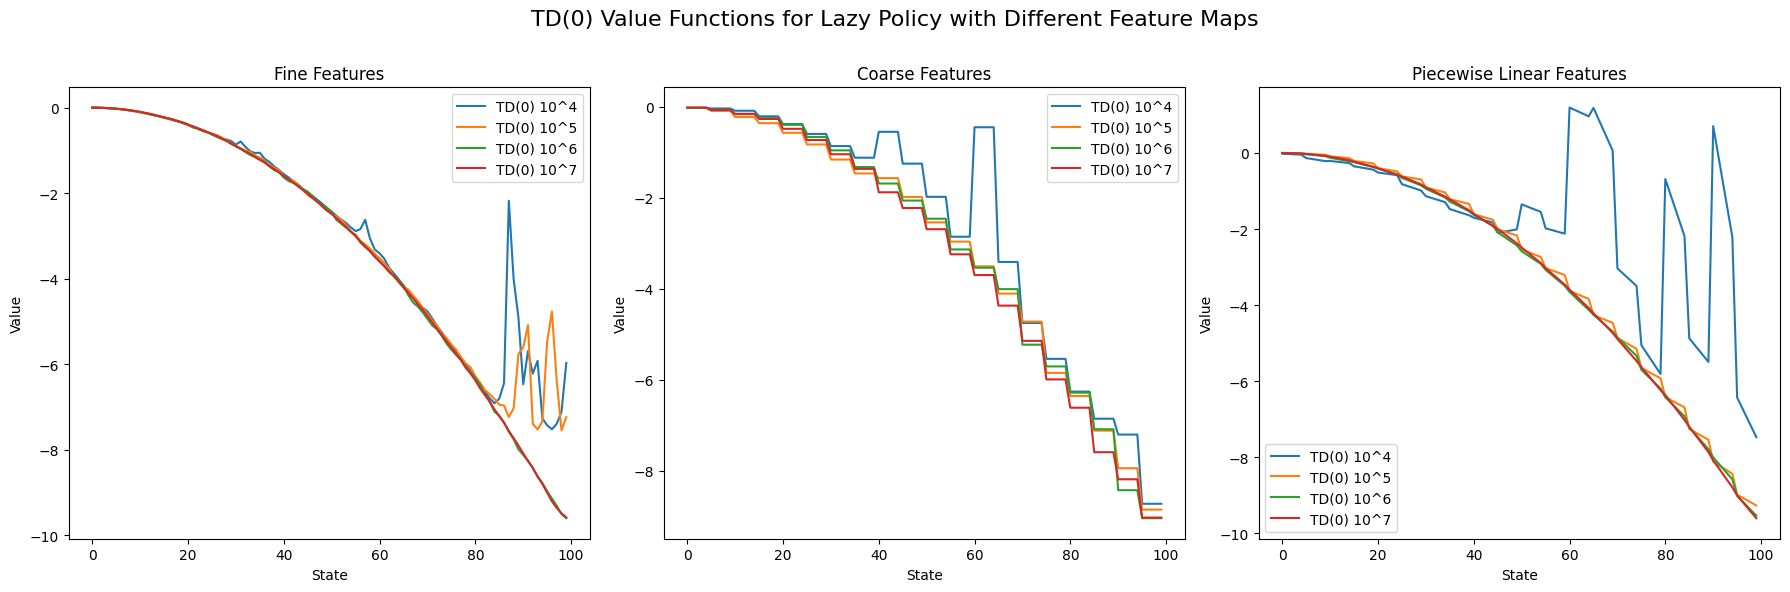

In [ ]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of feature maps and their titles
feature_maps = [fine_features, coarse_features, piecewise_linear_features]
titles = ["Fine Features", "Coarse Features", "Piecewise Linear Features"]

# Plotting
for idx, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    for sample_size in sample_sizes:
        transitions = sample_transitions(lazy_policy, N-1, sample_size, P)
        value_lazy = TD_0(transitions, a, b, gamma, feature_map, N)
        axes[idx].plot(value_lazy, label=f'TD(0) 10^{len(str(sample_size))-1}')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('State')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()

# Set overall title
fig.suptitle('TD(0) Value Functions for Lazy Policy with Different Feature Maps', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()


The fine feature map allows TD(0) on the lazy policy for a detailed representation of the environment, which can capture the subtleties in state values after enough sample transitions. So TD(0) is capturing the expected values across the state space fairly well.
The spikes are rather anomalies due to the stochastic nature of the sample transitions. But the overall trend indicates that TD(0) is converging properly.
Compared to the values from the last problem, the TD(0) fine features plot may show a similar shape, but with some noise present. This noise is not necessarily a sign of poor convergence; it may simply reflect the variance inherent in the TD(0) approach, especially when dealing with a smaler number of sample transitions.

The coarse feature map simplifies the state space, which can lead to a loss of detail in the value function. However, the TD(0) results with coarse features do not show significant variance, indicating that TD(0) converges to a stable solution even with a simplified representation of the state space.
The step-like pattern in the value function shows that the coarse features are not capturing the gradual changes in state values as effectively as fine features. Anyhow, the stable nature of the convergence is a positive aspect.

The piecewise linear features are a combination between fine and coarse representations, aiming to capture more detail than coarse features without the high variance that fine features can introduce. The TD(0) results show that this feature map produces a relatively stable value function approximation, indicating that the algorithm converges well with this level of detail.
These results are very aligned with the values benchmark.

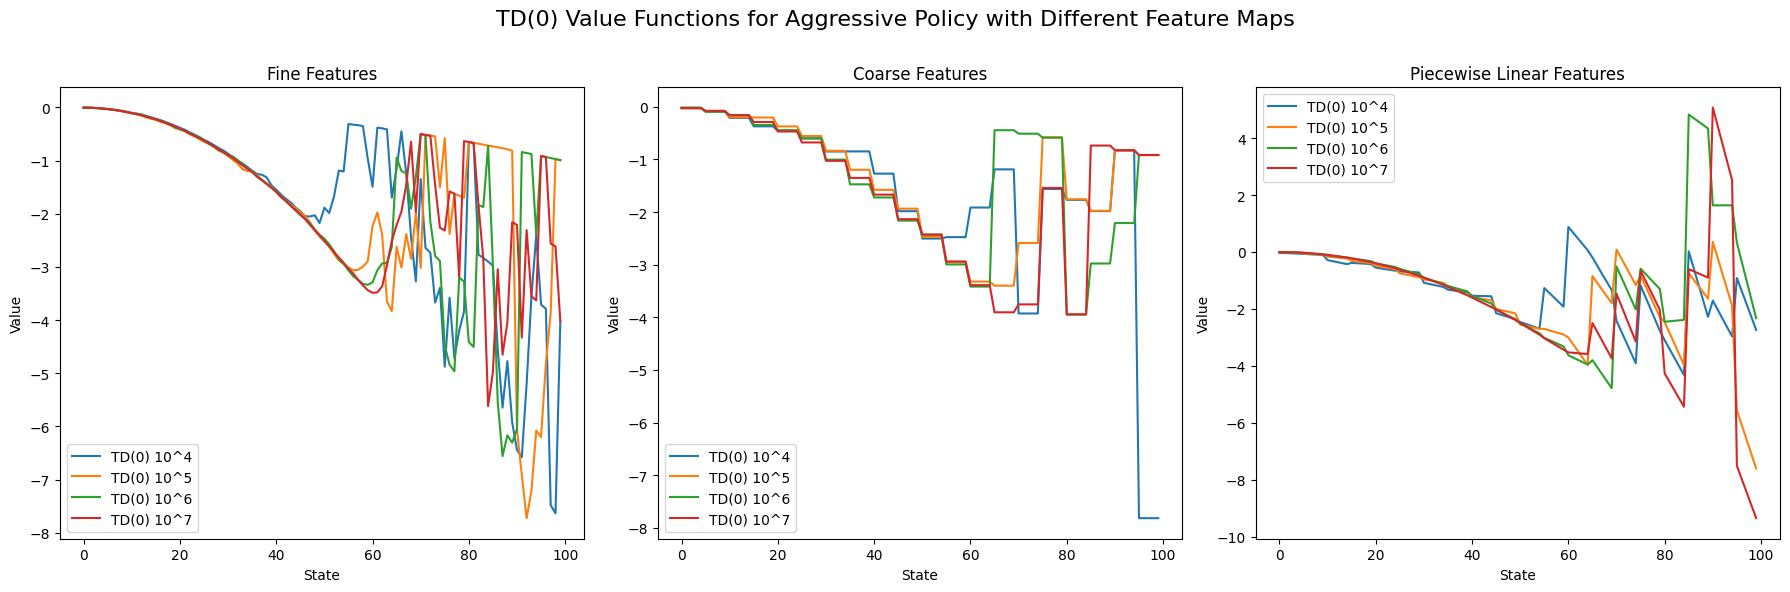

In [ ]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of feature maps and their titles
feature_maps = [fine_features, coarse_features, piecewise_linear_features]
titles = ["Fine Features", "Coarse Features", "Piecewise Linear Features"]

# Plotting
for idx, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    for sample_size in sample_sizes:
        transitions = sample_transitions(aggr_policy, N-1, sample_size, P)
        value_aggr = TD_0(transitions, a, b, gamma, feature_map, N)
        axes[idx].plot(value_aggr, label=f'TD(0) 10^{len(str(sample_size))-1}')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('State')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()

# Set overall title
fig.suptitle('TD(0) Value Functions for Aggressive Policy with Different Feature Maps', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()


The plots for TD(0) on agressive policy show a clear distinction before and after the threshold of state 50, which corresponds to the policy's switch from a low to a high service rate. The value functions before state 50 are relatively stable and consistent across sample sizes, indicating that TD(0) performs well in states where the policy is consistently applying a low service rate.
However, after state 50, there is a notable increase in variance and a lack of smoothness in the value functions even in the casses with more sample transitions. This suggests that TD(0) has difficulty converging to a stable value function in the region where the policy switches to the high service rate. The "messiness" in this part of the plot reflects the increased complexity and variability in outcomes that the aggressive policy introduces at higher states, with a tendency to go back to lower states in these cases.
This is valid for all 3 feature maps based on their same properties described in the TD(0) for lazy policy case.

In [ ]:

def LSTD(transitions, gamma, feature_map, N):

    num_features = feature_map.shape[1]

    A = np.zeros((num_features, num_features))
    b = np.zeros(num_features)

    # Accumulate A and b
    for (state, next_state, action) in transitions:

        phi_state = feature_map[state]
        phi_next_state = feature_map[next_state]

        A += np.outer(phi_state, phi_state - gamma * phi_next_state)
        b += phi_state * reward(state, action)

    # Solve for weights
    weights = np.linalg.pinv(A) @ b

    # Compute the value function for each state
    value_function = np.zeros(N)
    for state in range(N):
        phi_state = feature_map[state]
        value_function[state] = np.dot(weights, phi_state)

    return value_function


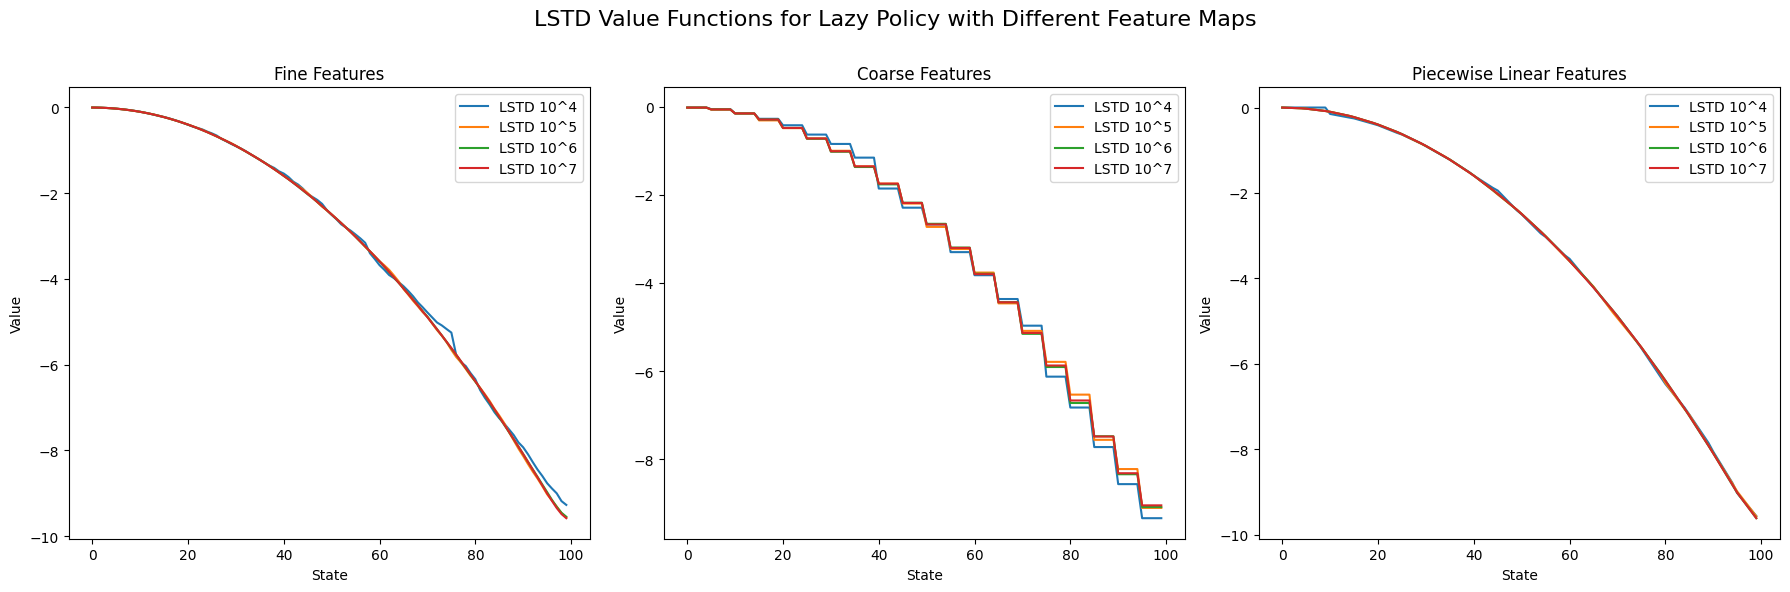

In [ ]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of feature maps and their titles
feature_maps = [fine_features, coarse_features, piecewise_linear_features]
titles = ["Fine Features", "Coarse Features", "Piecewise Linear Features"]

# Plotting for Lazy Policy
for idx, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    for sample_size in sample_sizes:
        transitions = sample_transitions(lazy_policy, N-1, sample_size, P)
        value_lazy = LSTD(transitions, gamma, feature_map, N)
        axes[idx].plot(value_lazy, label=f'LSTD 10^{len(str(sample_size))-1}')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('State')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()

# Set overall title
fig.suptitle('LSTD Value Functions for Lazy Policy with Different Feature Maps', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()


The value functions across different sample sizes show a high level of consistency, with very little variance, indicating that LSTD is effectively using the detailed information provided by the fine features to converge to a stable solution. The smoothness of the LSTD value functions is similar to that of the policy iteration benchmark from the last problem, suggesting that LSTD is accurately approximating the value function for the lazy policy.

The results with coarse features show a step-like function, similar to TD(0), but with much less variance between sample sizes. This pattern shows that LSTD with coarse features can still capture the policy's consistent application of a low service rate across all states. However, the transitions between states are not as smooth as with fine features, which is be due to the limited resolution of the coarse feature map.

The value functions produced by LSTD with piecewise linear features exhibit a balance between the detail of fine features and the simplicity of coarse features. The convergence here is smooth, and the results are very close to the actual value function, indicating that the piecewise linear feature map is suitable for the lazy policy when used in conjunction with LSTD as well.


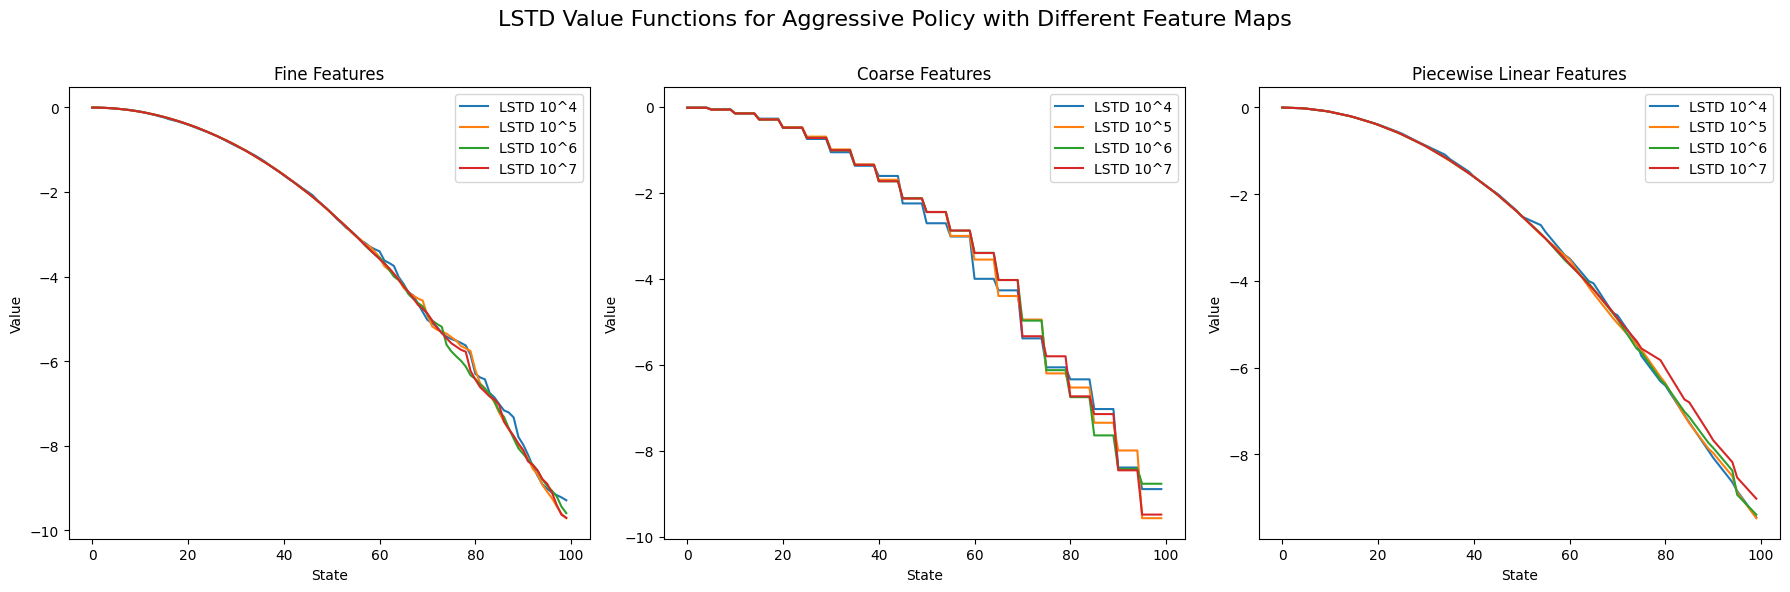

In [ ]:

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of feature maps and their titles
feature_maps = [fine_features, coarse_features, piecewise_linear_features]
titles = ["Fine Features", "Coarse Features", "Piecewise Linear Features"]

# Plotting for Aggressive Policy
for idx, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    for sample_size in sample_sizes:
        transitions = sample_transitions(aggr_policy, N-1, sample_size, P)
        value_aggr = LSTD(transitions, gamma, feature_map, N)
        axes[idx].plot(value_aggr, label=f'LSTD 10^{len(str(sample_size))-1}')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('State')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()

# Set overall title
fig.suptitle('LSTD Value Functions for Aggressive Policy with Different Feature Maps', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()


For the aggressive policy, the fine features with LSTD show a more nuanced representation of the value function than with TD(0). There is still some observable variance after state 50, where the policy switches from low to high service rates, but it is significantly reduced compared to the variance seen in the TD(0) results. This indicates that LSTD is more capable of handling the complexity introduced by the aggressive policy.

The plot with coarse features present a step-like appearance, especially after state 50, but with more consistency across sample sizes than seen in the TD(0) results. This suggests that while the coarse features may not capture all the subtleties of the aggressive policy, LSTD is still able to provide a relatively stable approximation of the value function.

The piecewise linear features seem to offer a good representation of the policy's value function, as the LSTD results show a clear and stable approximation before and after state 50. Although there's some variance, it's much less pronounced than in the TD(0) results, and the overall trend closely matches the benchmark.

In [ ]:
def approximate_policy_iteration(P, max_iter, start_state, gamma, feature_map):
    # Initialize a random policy
    policy = [np.random.choice([0, 1]) for _ in range(N)]  # Randomly choose an action for each state

    for k in range(max_iter):
        # Policy Evaluation: Using LSTD

        transitions = sample_transitions(policy, start_state, 100000, P)
        V = LSTD(transitions, gamma, feature_map, N)

        # Policy Improvement: Update the policy based on the Q-function estimate
        policy_stable = True
        for x in range(N):
            old_action = np.argmax(policy[x])

            # Initialize an array to store Q-values for each action
            Q_values = np.zeros(2)

            # Compute Q-value for each action
            for a in range(2):
                q_action = q_low if a == 0 else q_high  # Replace with your method to determine q(a)

                # Q-value computation incorporating the transition dynamics
                Q_values[a] = ( reward(x, a)
                              + gamma * (1 - p) * ( q_action * V[max(x - 1, 0)] + ( 1 - q_action ) * V[x] )
                              + gamma * p * ( q_action * V[x] + ( 1 - q_action ) * V[min(x + 1, 99)] )
                )

            # Choose the action with the highest Q-value
            best_action = np.argmax(Q_values)
            policy[x] = best_action

            if old_action != best_action:
                policy_stable = False

        # Break if the policy is stable
        if policy_stable:
            break

    return policy, V


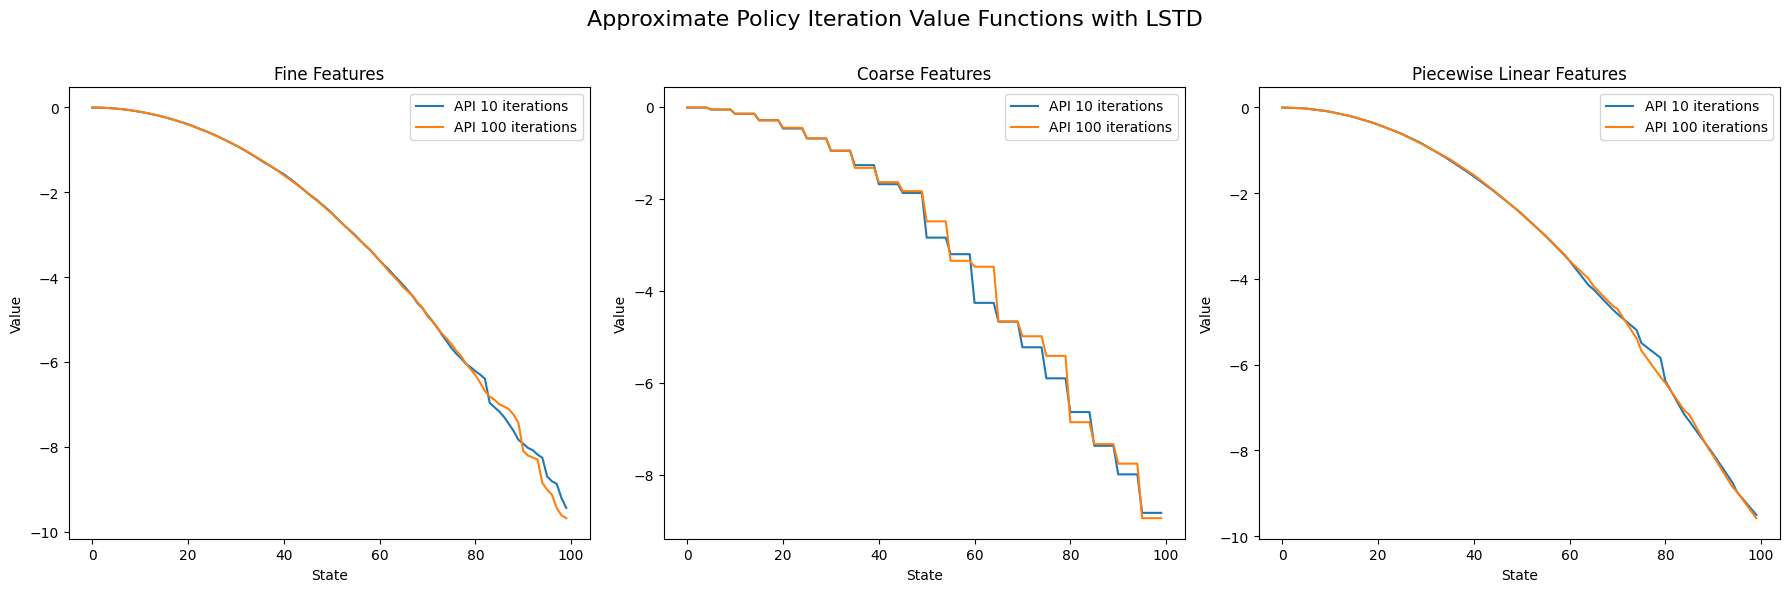

In [18]:
# Plot Approximate Policy Iteration Value Functions with LSTD

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of feature maps and their titles
feature_maps = [fine_features, coarse_features, piecewise_linear_features]
titles = ["Fine Features", "Coarse Features", "Piecewise Linear Features"]

# Plotting for API
for idx, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    for iteration in [10,100]:
        _ , vf_api = approximate_policy_iteration(P, iteration, N-1, gamma, feature_map )
        axes[idx].plot(vf_api, label=f'API {iteration} iterations')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('State')
    axes[idx].set_ylabel('Value')
    axes[idx].legend()

# Set overall title
fig.suptitle('Approximate Policy Iteration Value Functions with LSTD', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()

The value functions for both 10 and 100 iterations across all feature maps show a consistent improvement with more iterations, suggesting that the API is effectively refining the policy.
For fine features, the value function at 100 iterations is smooth and closely follows the curve, indicating a good approximation of the optimal value function.
Coarse features show a more step-wise function which may indicate some underfitting, but there is still noticeable improvement from 10 to 100 iterations.
The piecewise linear features show a smooth value function similar to fine features, suggesting that this feature map also provides a good approximation with API.

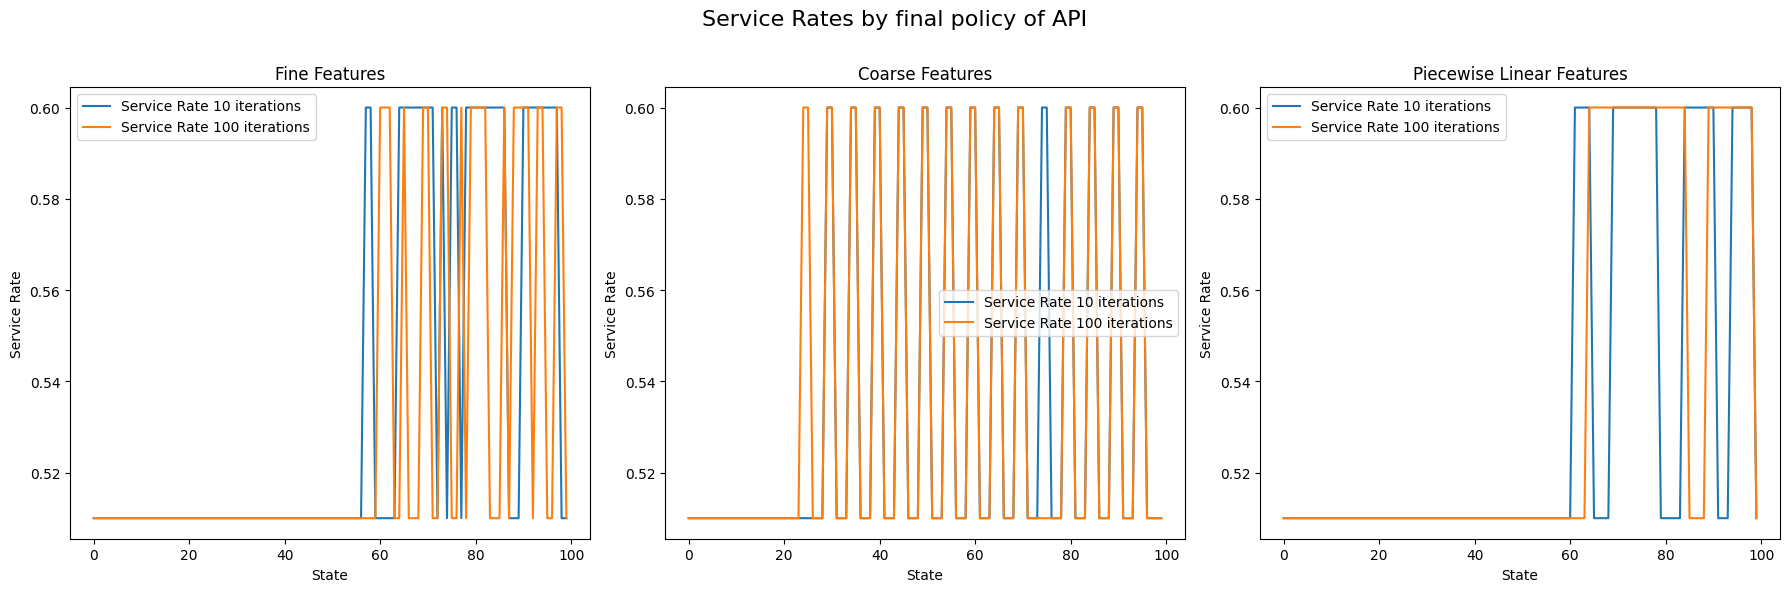

In [19]:
# Plot the service rates

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# List of feature maps and their titles
feature_maps = [fine_features, coarse_features, piecewise_linear_features]
titles = ["Fine Features", "Coarse Features", "Piecewise Linear Features"]

# Plotting for API
for idx, (feature_map, title) in enumerate(zip(feature_maps, titles)):
    for iteration in [10,100]:
        policy_api , _ = approximate_policy_iteration(P, iteration, N-1, gamma, feature_map )

        service_rates = [q_low if action == 0 else q_high for action in policy_api]

        axes[idx].plot(service_rates, label=f'Service Rate {iteration} iterations')
    axes[idx].set_title(title)
    axes[idx].set_xlabel('State')
    axes[idx].set_ylabel('Service Rate')
    axes[idx].legend()

# Set overall title
fig.suptitle('Service Rates by final policy of API', fontsize=16)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.85)

# Show plot
plt.show()

The service rates by the final policy of API after 100 iterations show a clear policy structure, particularly with fine features, where there's a discernible difference in service rates for different states.
The piecewise linear and coarse features show less distinction in service rates across states. However, there is a visible difference between the 10 and 100 iterations, indicating that the policy is evolving.
The service rate plots suggest that the final policy is increasingly making more nuanced decisions as the number of iterations grows.

Comparing these results to the optimal value functions and policies from the first problem set, it appears that the final policy has robustly improved on the initial policy.
The improvement is evident in the value functions' convergence and the service rates' alignment with the expected optimal policy behavior.
The final policy, especially after 100 iterations, likely represents a substantial improvement over the initial policy, as shown by the closer approximation to the optimal value function and the more defined service rates.